# Emotion Dataset — EDA & Preprocessing Checks

This notebook inspects split sizes and class balance, validates image paths, and previews a few images.


In [6]:
import os
import json
import pandas as pd 
import matplotlib.pyplot as plt

In [15]:
# Paths (adjust if your files live elsewhere)
CSV_TRAIN = r"C:\Users\ASUS\Documents\ann-visual-emotion\data\processed\EmoSet_splits\train.csv"
CSV_VAL   = r"C:\Users\ASUS\Documents\ann-visual-emotion\data\processed\EmoSet_splits\val.csv"
CSV_TEST  = r"C:\Users\ASUS\Documents\ann-visual-emotion\data\processed\EmoSet_splits\test.csv"
LABEL_MAP_JSON = r"C:\Users\ASUS\Documents\ann-visual-emotion\data\processed\EmoSet_splits\label_map.json"
STATS_JSON     = r"C:\Users\ASUS\Documents\ann-visual-emotion\data\processed\EmoSet_splits\stats.json"
assert os.path.exists(CSV_TRAIN), f"Missing {CSV_TRAIN}"
assert os.path.exists(CSV_VAL),   f"Missing {CSV_VAL}"
assert os.path.exists(CSV_TEST),  f"Missing {CSV_TEST}"

In [16]:
train_df = pd.read_csv(CSV_TRAIN)
val_df   = pd.read_csv(CSV_VAL)
test_df  = pd.read_csv(CSV_TEST)

In [20]:
display(train_df.head())
display(val_df.head())
display(test_df.head())

,image_path,label
0,data/raw/EmoSet/contentment/contentment_09260.jpg,contentment
1,data/raw/EmoSet/anger/anger_06224.jpg,anger
2,data/raw/EmoSet/contentment/contentment_03550.jpg,contentment
3,data/raw/EmoSet/sadness/sadness_08827.jpg,sadness
4,data/raw/EmoSet/contentment/contentment_09558.jpg,contentment


,image_path,label
0,data/raw/EmoSet/amusement/amusement_03323.jpg,amusement
1,data/raw/EmoSet/contentment/contentment_01769.jpg,contentment
2,data/raw/EmoSet/excitement/excitement_19925.jpg,excitement
3,data/raw/EmoSet/amusement/amusement_05206.jpg,amusement
4,data/raw/EmoSet/contentment/contentment_09125.jpg,contentment


,image_path,label
0,data/raw/EmoSet/excitement/excitement_02484.jpg,excitement
1,data/raw/EmoSet/amusement/amusement_18998.jpg,amusement
2,data/raw/EmoSet/excitement/excitement_02958.jpg,excitement
3,data/raw/EmoSet/excitement/excitement_00670.jpg,excitement
4,data/raw/EmoSet/excitement/excitement_02275.jpg,excitement


Columns in train_df: ['image_path', 'label']


,image_path,label
0,data/raw/EmoSet/contentment/contentment_09260.jpg,contentment
1,data/raw/EmoSet/anger/anger_06224.jpg,anger
2,data/raw/EmoSet/contentment/contentment_03550.jpg,contentment
3,data/raw/EmoSet/sadness/sadness_08827.jpg,sadness
4,data/raw/EmoSet/contentment/contentment_09558.jpg,contentment


## Split sizes


In [22]:
sizes = {
    "train": len(train_df),
    "val":   len(val_df),
    "test":  len(test_df),
}
sizes

{'train': 13864, 'val': 1734, 'test': 1734}

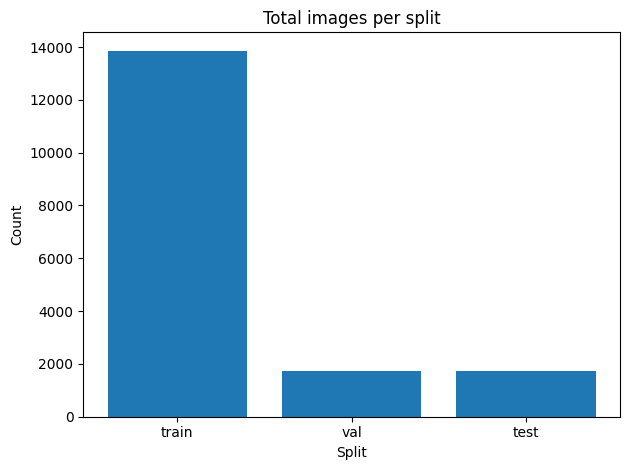

In [23]:
# Bar: total per split (matplotlib only, one figure per chart, no styles/colors set)
plt.figure()
plt.bar(list(sizes.keys()), list(sizes.values()))
plt.title("Total images per split")
plt.xlabel("Split")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


## Class distribution per split


In [24]:
def plot_class_dist(df, split_name):
    vc = df['emotion'].value_counts().sort_index()
    plt.figure()
    plt.bar(vc.index.tolist(), vc.values.tolist())
    plt.title(f"Class distribution — {split_name}")
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

plot_class_dist(train_df, "train")
plot_class_dist(val_df, "val")
plot_class_dist(test_df, "test")


KeyError: 'emotion'